In [9]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

In [2]:
data_dir = '/Users/gbromley/data/CRU/pre/'
temp_file = 'cru_ts3.24.1901.2015.pre.dat.nc'

nc_var = xr.open_dataset(data_dir+temp_file)

In [3]:
var = nc_var['pre']

In [5]:
t_season='AMJ'
t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2015-12-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38
var = var.sel(lat=slice(ext_s-5,ext_n+5),lon=slice(ext_w-5,ext_e+5))
#ggw_lat,ggw_lon = 48.18, -106.635

In [6]:
#extract the time period we are interested in
var_slice=var.sel(time=slice(start_year,end_year))
#grab the months interested in
var_months = var_slice.sel(time=extract_months(var_slice['time.month'],t_months[0],t_months[-1]))
#create month averages
var_months_avg = var_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
var_clim_30= var.sel(time=slice('1981-01-01','2010-12-01'))
#grab the months
var_clim_months_30 = var_clim_30.sel(time=extract_months(var_clim_30['time.month'],t_months[0],t_months[-1]))
#create averages over months for climate normal
var_clim_months_avg = var_clim_months_30.mean(dim='time')

In [7]:
#create 2d structure to hold slope
spatial_trend = var.isel(time=1).copy(deep=True)
spatial_trend.name = 'pre_trend'
spatial_trend.attrs['units'] = 'mm per Decade'
spatial_trend.attrs['long_name'] = 'precip trend'

#create 2d structure to hold pvalues
pvalues= var.isel(time=1).copy(deep=True)
pvalues.name = 'pre_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = 'precip trend pvalues'

In [19]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(var_months_avg))
corr_vals_2 = sm.add_constant(corr_vals)
for i in np.arange(0,len(var['lat'])):
    for j in np.arange(0,len(var['lon'])):
        series = var_months_avg[:,i,j]
        anom = series - var_clim_months_avg[i,j]
        model = sm.OLS(anom.values,corr_vals_2)
        #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
        results = model.fit()
        slope = results.params[1]
        t_value = ((slope - 0)/results.bse[1])
        p_value = stats.t.cdf(t_value, results.df_resid)
       # p_value = stats.t.sf(results.tvalues[0], results.df_resid)
        spatial_trend[i,j]=slope*10
        #slope_scipy[i,j] = slope_2*10
        pvalues[i,j]= results.pvalues[1]
        #print(i)

/Users/gbromley/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/gbromley/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/gbromley/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [18]:
results.pvalues[1]

/Users/gbromley/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/gbromley/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/gbromley/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


nan

In [14]:
pvals = pvalues.where(pvalues.values < 0.05)

/Users/gbromley/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


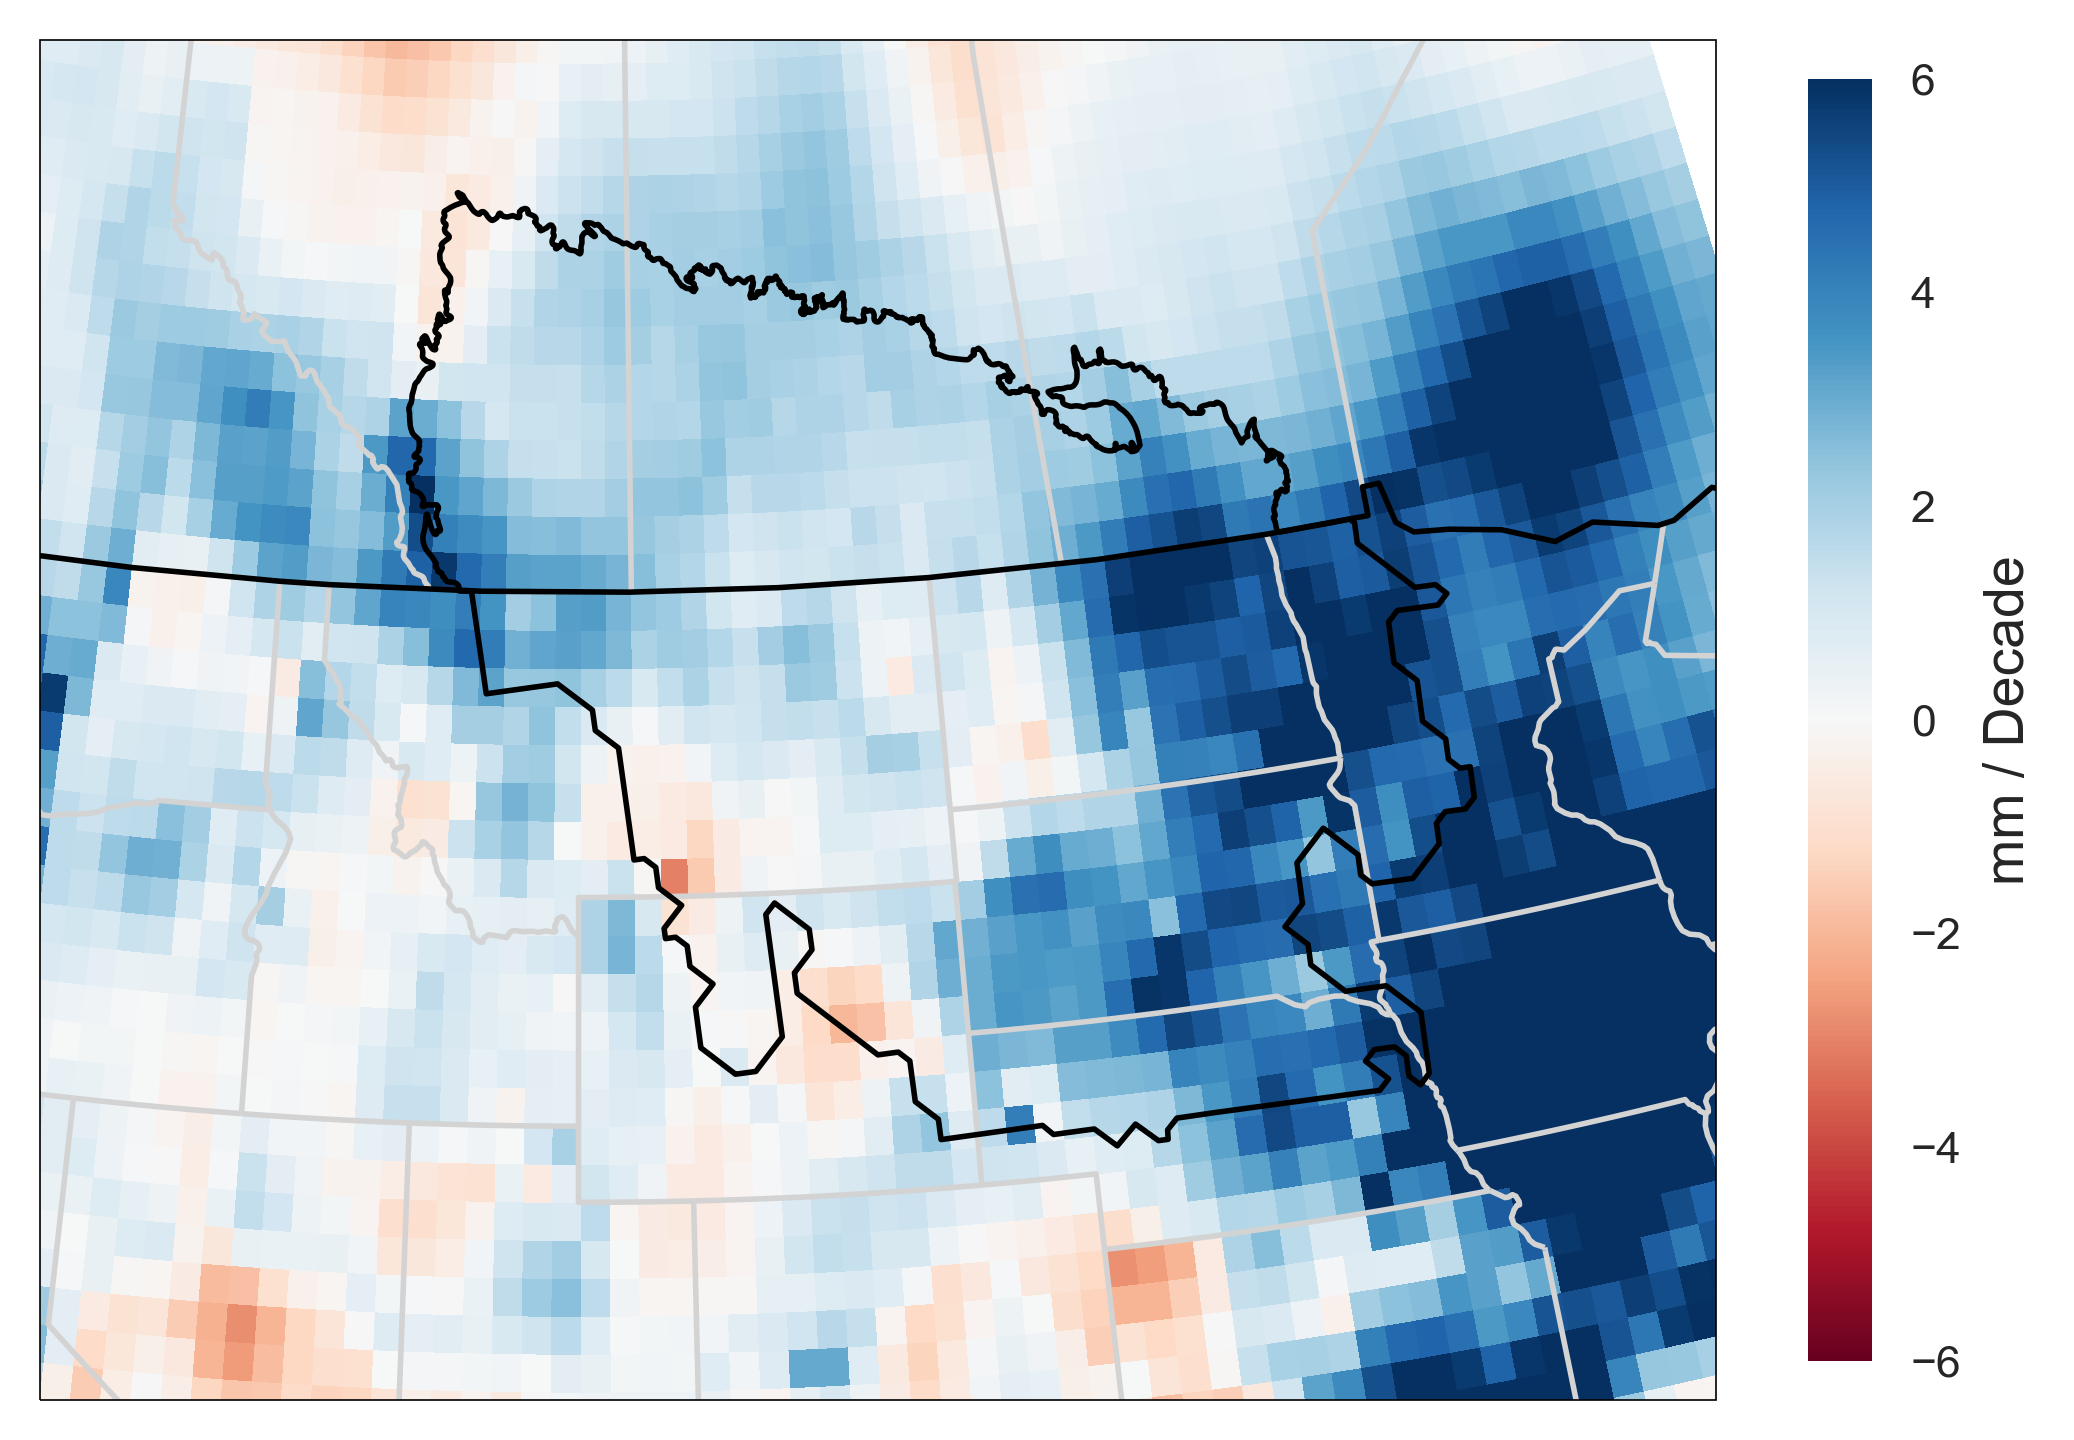

In [20]:
fig = plt.figure(1,figsize=(13,7), dpi=400.0)
projection = ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None)
ax1 = plt.subplot(1,2,1, projection = projection)
#ax1 = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax1.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax1, transform=ccrs.PlateCarree(),vmin=-6, vmax=6, cmap='RdBu',add_colorbar = False)
#ax = plt.axes(projection=ccrs.LambertConformal())
pvals.plot.contourf(axes=ax1,transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches="..",alpha=0.,add_colorbar = False)
ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
shape_feature = ShapelyFeature(Reader('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/Study_Area_08_01_17.shp').geometries(),crs=ccrs.PlateCarree(), facecolor='none',edgecolor='black')
ax1.add_feature(shape_feature)
#plt.plot(ggw_lon, ggw_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.plot(ftp_lon, ftp_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.text(ftp_lon+0.5, ftp_lat, 'US-FPe', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
#plt.text(ggw_lon-2, ggw_lat, 'GGW', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
ax1.title.set_visible(False)
cb = plt.colorbar(test, cmap='RdBu',fraction=0.035)
cb.set_label('mm / Decade',fontsize=10)
cb.ax.tick_params(labelsize=8)
#plt.text(0, 1,'a', ha='center', va='center', backgroundcolor='lightgray')
#anchored_text = AnchoredText("1", loc=2)
#ax1.add_artist(anchored_text)

#plt.savefig('CRU_precip_sig_trends'+t_season+'_1970.png',bbox_inches='tight')
plt.show()



<xarray.DataArray 'tmp' (time: 123, lat: 360, lon: 720)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...